In [16]:
import numpy as np 
import gym
from collections import defaultdict
import sys
import json
import matplotlib.pyplot as plt
from plot_utils import plot_policy


In [2]:
env = gym.make('Blackjack-v1')
state = env.reset()
action_space = env.action_space.n

In [3]:
print(state)
print(action_space)
# ((player_sum, dealer_card_showing, useable_ace))
# hit or stick

((12, 4, False), {})
2


In [6]:
num_episodes = 1000
epsilon = 1
epsilon_min = 0.05
alpha = 0.02

In [7]:
def epsilon_greedy_policy(Q,state,epsilon):
    probs = np.zeros(2)
    optimal_action = np.argmax(Q[state[0]])
    sub_optimal_action = np.abs(optimal_action - 1)
    
    probs[optimal_action] = 1 - epsilon + (epsilon/2)
    probs[sub_optimal_action] = epsilon/2
    
    #choose an action according to probs
    action = np.random.choice(np.arange(2),p = probs)
    return action

In [8]:
def generate_episode(Q,epsilon):
    state = env.reset()
    episode = []
    while True:
        action = epsilon_greedy_policy(Q,state,epsilon)
        next_state,reward,done,info = env.step(action)[0:4]
        state = next_state
        episode.append((state,action,reward))

        if done == True:
            break
    return episode

In [10]:
def monte_carlo_control(num_episodes,epsilon,epsilon_min,alpha,gamma=1):
    Q = defaultdict(lambda: np.zeros(2))
    rewards_all_episodes = []
    for episodes in range(1,num_episodes+1):
        epsilon = max(epsilon_min,epsilon*0.999999) #decaying epsilon
        if episodes % 10 == 0:
            print('\rEpisode {}/{}'.format(episodes,num_episodes),end="")
        
        experience = generate_episode(Q,epsilon)
        states,actions,rewards = zip(*experience)
        rewards = np.array(rewards)
        rewards_all_episodes.append(sum(rewards))
        for i,state in enumerate(states):
            discounts = np.array([gamma**i for i in range(len(rewards[i:]))])
            returns = sum(rewards[i:] * discounts)
            Q[state][actions[i]] += alpha* (returns - Q[state][actions[i]])
            policy = dict((state,np.argmax(q_value)) for state,q_value in Q.items())
    return Q,policy,rewards_all_episodes
            
        

In [11]:
Q,policy,rewards_all_episodes = monte_carlo_control(num_episodes,epsilon,epsilon_min,alpha)

c:\Users\aksha\anaconda2\envs\aipytorch\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1000/1000

In [ ]:
def plot_win_rate(rewards_all_episodes, num_episodes):

    # using the optimal policy 
    rewards_optimal = np.array(rewards_all_episodes)
    rewards_optimal = np.array([0 if x == -1 else x for x in rewards_optimal])
    rewards_optimal = rewards_optimal.cumsum()
    win_rate_optimal = rewards_optimal / np.arange(1, num_episodes+1)

    # using a completely random policy 
    file = open('misc/rewards.json', 'r')
    rewards_all_random = json.load(file)
    file.close()

    rewards_random = np.array(rewards_all_random)
    if len(rewards_all_episodes) <= 1000000:    
        rewards_random = rewards_random[0:len(rewards_all_episodes)]
        rewards_random = np.array([0 if x == -1 else x for x in rewards_random])
        rewards_random = rewards_random.cumsum()
        win_rate_random = rewards_random / np.arange(1, num_episodes+1)
    else:
        rewards_random = np.array(rewards_all_random)
        rewards_random = np.array([0 if x == -1 else x for x in rewards_random])
        rewards_random = rewards_random.cumsum()
        win_rate_random = rewards_random / np.arange(1, 1000000+1)
        
    plt.plot(np.arange(1, num_episodes+1), win_rate_optimal)
    plt.plot(np.arange(1, num_episodes + 1), win_rate_random)
    plt.legend(['Optimal Policy', 'Random Policy'])
    plt.show()

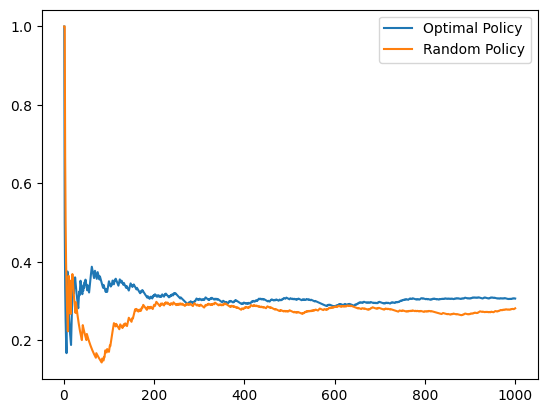

In [13]:
plot_win_rate(rewards_all_episodes,num_episodes)

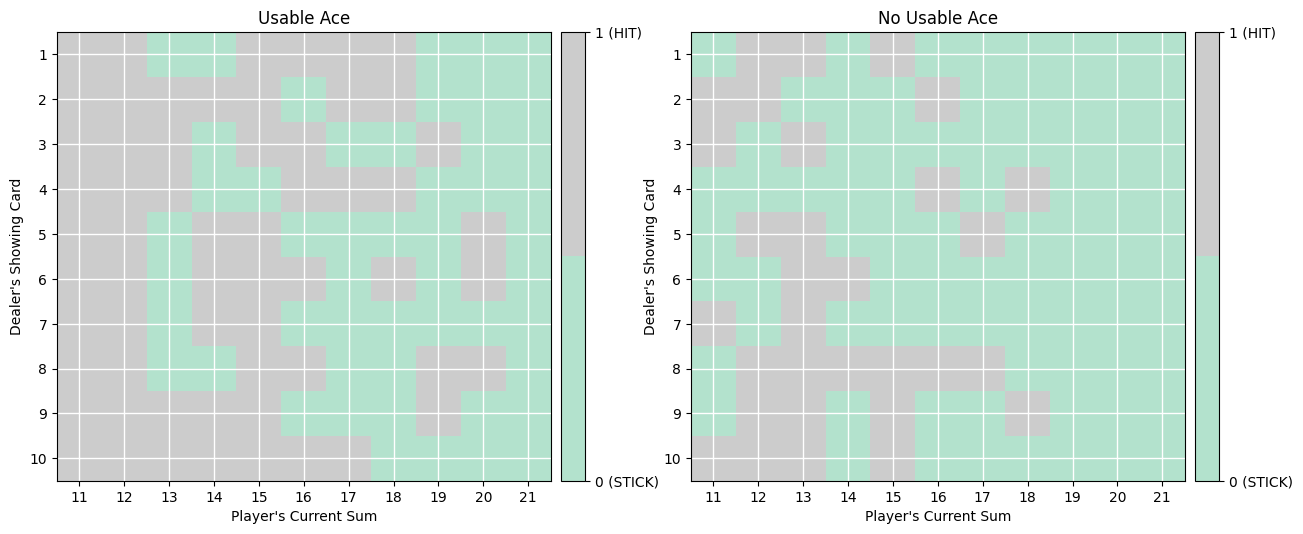

In [17]:
plot_policy(policy)